In [1]:
import os
import sys
from matplotlib import pyplot as plt
sys.path.append('Lab02_NMT')

import numpy as np
import pandas as pd
from tqdm import tqdm
import yaml
import json
import librosa
from librosa import display as ld
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader

from neural_network import NN_CATALOG
from dataset.bird_clef import load_wav
from dataset.augmentations import Normalize


Bad key text.latex.preview in file /home/cherepaha/miniconda/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/cherepaha/miniconda/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/cherepaha/miniconda/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # w

In [2]:
bird_tax = pd.read_csv('data/eBird_Taxonomy_v2021.csv', index_col=0)
train_meta = pd.read_csv('data/train_metadata_extended.csv')
with open('data/scored_birds.json') as fin:
    scored_birds = json.load(fin)

In [3]:
train_meta.loc[:, 'secondary_labels'] = train_meta.secondary_labels.apply(eval)
train_meta['target_raw'] = train_meta.secondary_labels + train_meta.primary_label.apply(lambda x: [x])

In [4]:
all_species = sorted(set(train_meta.target_raw.sum()))
species2id = {s: i for i, s in enumerate(all_species)}
id2species = {i: s for i, s in enumerate(all_species)}

train_meta['target'] = train_meta.target_raw.apply(lambda species: [int(s in species) for s in all_species])

In [5]:
test_meta = train_meta[train_meta.duration > 60]

In [6]:
data_root = 'data/train_audio/'
test_fnames = test_meta.filename.values.tolist()

### Dataset

In [7]:
class TestDataset(Dataset):
    def __init__(self, data_root, fnames, augmentations=None):
        super().__init__()
        self.data_root = data_root
        self.fnames = fnames
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        fpath = os.path.join(self.data_root, self.fnames[idx])
        wav, sr = load_wav(fpath, 0, 60)
        if self.augmentations:
            wav = self.augmentations(wav, None)
        wav = torch.tensor(wav)      
        assert (13 * 5 * sr) > len(wav) 
        wav = wav[:len(wav) // 12 * 12].reshape((12, len(wav) // 12))
        return wav

In [8]:
test_dataset = TestDataset(
    data_root,
    test_fnames, 
    augmentations=Normalize(p=1)
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    drop_last=False,   
)

<AxesSubplot:>

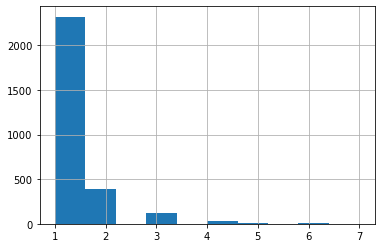

In [9]:
test_meta.target.apply(sum).hist()

### Model

In [133]:
config_path = 'submit/model_ckpt/baseline_config.yaml'
model_path = 'Lab02_NMT/model_save/baseline_3cduxuvr/final-model.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open(config_path) as fin:
    config = yaml.safe_load(fin)

model_config = config['model']
model_config['params']['backbone_config']['pretrained'] = False
data_config = config['data']
model_class = NN_CATALOG[model_config['name']]

model = model_class(len(all_species), int(data_config['crop_len'] // data_config['test_wav_len']),
                    **model_config['params'])
model.to(device)

state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [134]:
test_birds = list(set(test_meta.target_raw.sum()))
test_birds = sorted(test_birds)

In [135]:
pred_list = []
treshold = 0.1
model.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_dataloader)):
        batch_size, part_count, part_size = batch.shape
        batch = batch.reshape(batch_size * part_count, part_size)
        pred = model(batch.to(device))['logits']
        pred = pred.cpu().numpy()
#         pred = pred > treshold
        
        for j, chunk_pred in enumerate(pred):
            inbatch_number = j // part_count
            chunk_number = j % part_count + 1
            f_idx = i * batch_size + inbatch_number
            
            fname = test_dataset.fnames[f_idx]
            
            pred_list.extend([{
                'filename': fname,
                'right': 5 * chunk_number,
                'left': 5 * chunk_number - 5,
                'bird': b,
                'pred': chunk_pred[species2id[b]]
            } for b in test_birds])
pred_pd = pd.DataFrame(pred_list)

2885it [00:58, 49.62it/s]


In [147]:
pred_pd.to_csv('focal_pred.csv', index=False)

['apapan', 'iiwi', 'warwhe1', 'akepa1']
['afrsil1' 'akekee' 'akepa1' 'akiapo' 'amewig' 'aniani' 'apapan' 'arcter'
 'barpet' 'bcnher' 'belkin1' 'bkbplo' 'bknsti' 'bkwpet' 'blkfra' 'blknod'
 'bongul' 'brant' 'brnboo' 'brnowl' 'brtcur' 'buffle' 'bulpet' 'burpar'
 'buwtea' 'cacgoo1' 'calqua' 'cangoo' 'canvas' 'caster1' 'categr' 'chukar'
 'cintea' 'comgal1' 'commyn' 'compea' 'comsan' 'comwax' 'crehon' 'dunlin'
 'elepai' 'eurwig' 'fragul' 'gadwal' 'gamqua' 'glwgul' 'gnwtea' 'golphe'
 'grbher3' 'grefri' 'gresca' 'gryfra' 'gwfgoo' 'hawama' 'hawcre' 'hawhaw'
 'hawpet1' 'hoomer' 'houfin' 'houspa' 'hudgod' 'iiwi' 'incter1' 'jabwar'
 'japqua' 'kalphe' 'laugul' 'lcspet' 'leasan' 'leater1' 'lessca' 'lesyel'
 'lobdow' 'lotjae' 'madpet' 'magpet1' 'mallar3' 'maupar' 'merlin' 'mitpar'
 'moudov' 'norcar' 'norhar2' 'normoc' 'norpin' 'norsho' 'nutman' 'oahama'
 'omao' 'osprey' 'pagplo' 'parjae' 'pecsan' 'peflov' 'perfal' 'pibgre'
 'pomjae' 'reccar' 'redava' 'redjun' 'redpha1' 'refboo' 'rempar' 'rettro'
 'r

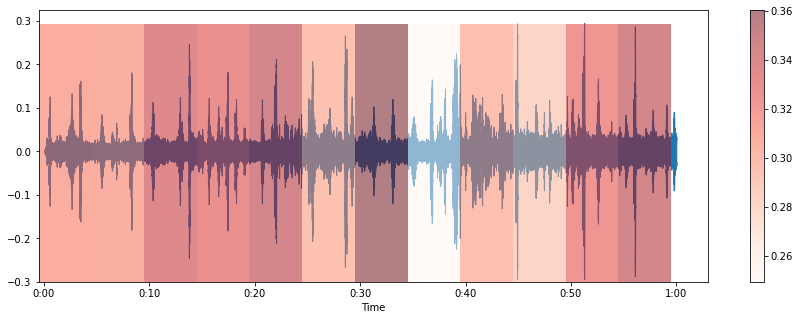

In [138]:
idx = 4
fig, ax = plt.subplots(figsize=(15, 5))
fname = test_meta.iloc[idx]['filename']
fpath = os.path.join('data/train_audio/', fname)
wav, sr = load_wav(fpath, 0, 60)
ld.waveshow(wav, sr=sr, ax=ax)

sample_pred = pred_pd[(pred_pd.filename == fname) & (pred_pd.pred)]
sample_birds = sample_pred.bird.unique()
bird_to_plot = test_meta.iloc[idx]['target_raw'][2]
bird_pred = sample_pred[sample_pred.bird == bird_to_plot]
# bird_pred.loc[:, 'right'] = bird_pred.right * sr
# bird_pred.loc[:, 'left'] = bird_pred.left * sr

# for i, row in bird_pred.iterrows():
#     ax.fill_betweenx(
#         [wav.min(), wav.max()],
#         row.left, row.right,
#         alpha=0.3,
#         color='orange',
#         edgecolor="none"
#     )

nx = 60
x = np.linspace(0,nx-1,nx)
y = np.linspace(wav.min(), wav.max(), 50)
X,Y = np.meshgrid(x, y, indexing='ij')
Z = X * 0 # set a fancy Z function

for i, row in bird_pred.iterrows():
    Z[row.left:row.right, :] = row.pred

# fig = plt.figure(figsize=(22,11)) 
# ax1 = fig.add_subplot(121)
pc = ax.pcolormesh(X, Y, Z, edgecolors='none',cmap="Reds", alpha=0.5)
fig.colorbar(pc)
print(test_meta.iloc[idx]['target_raw'])
print(sample_birds)

In [139]:
per_wav_stat = pred_pd.groupby(['filename', 'bird']).agg(
    mean=('pred', np.mean),
    std=('pred', np.std),
).reset_index()

per_wav_stat['rank'] = per_wav_stat.groupby('filename')['mean'].rank(ascending=False)

In [140]:
per_wav_stat = per_wav_stat.merge(test_meta[['filename', 'target_raw']], on='filename')
gt_stat = per_wav_stat[per_wav_stat.apply(lambda x: x.bird in x.target_raw, axis=1)]

In [141]:
per_bird_stat = gt_stat.groupby('bird').agg(
    mean=('mean', np.mean),
    std=('std', np.mean),
    rank=('rank', np.mean),
    f_count=('filename', 'count')
)

In [146]:
per_bird_stat.to_csv('focal_stat.csv', index=True)

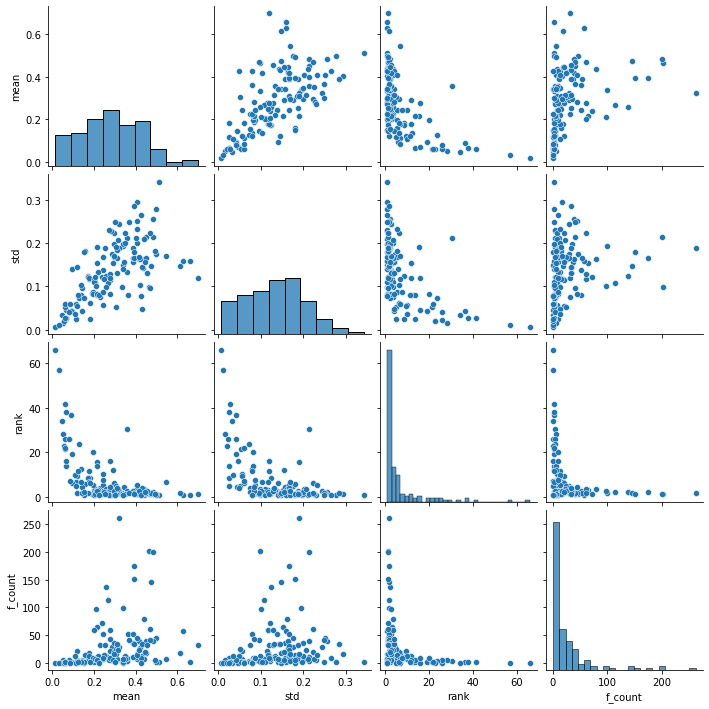

In [142]:
sns.pairplot(per_bird_stat)

In [143]:
focal_stat = per_bird_stat

In [112]:
maxpool_stat = pd.read_csv('maxpool_stat.csv', index_col=0)
maxpool_stat

,mean,std,rank,f_count
bird,,,,
afrsil1,0.000641,0.001376,42.000000,1
akekee,0.134846,0.214917,1.500000,2
akepa1,0.076107,0.035914,5.555556,9
akiapo,0.070648,0.053287,8.000000,8
amewig,0.199945,0.183996,3.363636,11
...,...,...,...,...
whttro,0.066439,0.098267,1.500000,2
wiltur,0.294654,0.314455,3.242424,33
yebcar,0.639334,0.255884,1.000000,1


In [117]:
global_target = np.array([t for t in train_meta.target])
bird_ratio = global_target.mean(axis=0)

(152,)

In [144]:
focal_stat.reset_index(inplace=True)
focal_stat['proportion'] = focal_stat.bird.apply(lambda x: bird_ratio[species2id[x]])
focal_stat.set_index('bird', inplace=True)

In [119]:
baseline_stat.reset_index(inplace=True)
maxpool_stat.reset_index(inplace=True)

baseline_stat['proportion'] = baseline_stat.bird.apply(lambda x: bird_ratio[species2id[x]])
maxpool_stat['proportion'] = maxpool_stat.bird.apply(lambda x: bird_ratio[species2id[x]])

baseline_stat.set_index('bird', inplace=True)
maxpool_stat.set_index('bird', inplace=True)

In [129]:
baseline_stat['model'] = 'baseline'
maxpool_stat['model'] = 'maxpool'

In [145]:
focal_stat['model'] = 'focal'

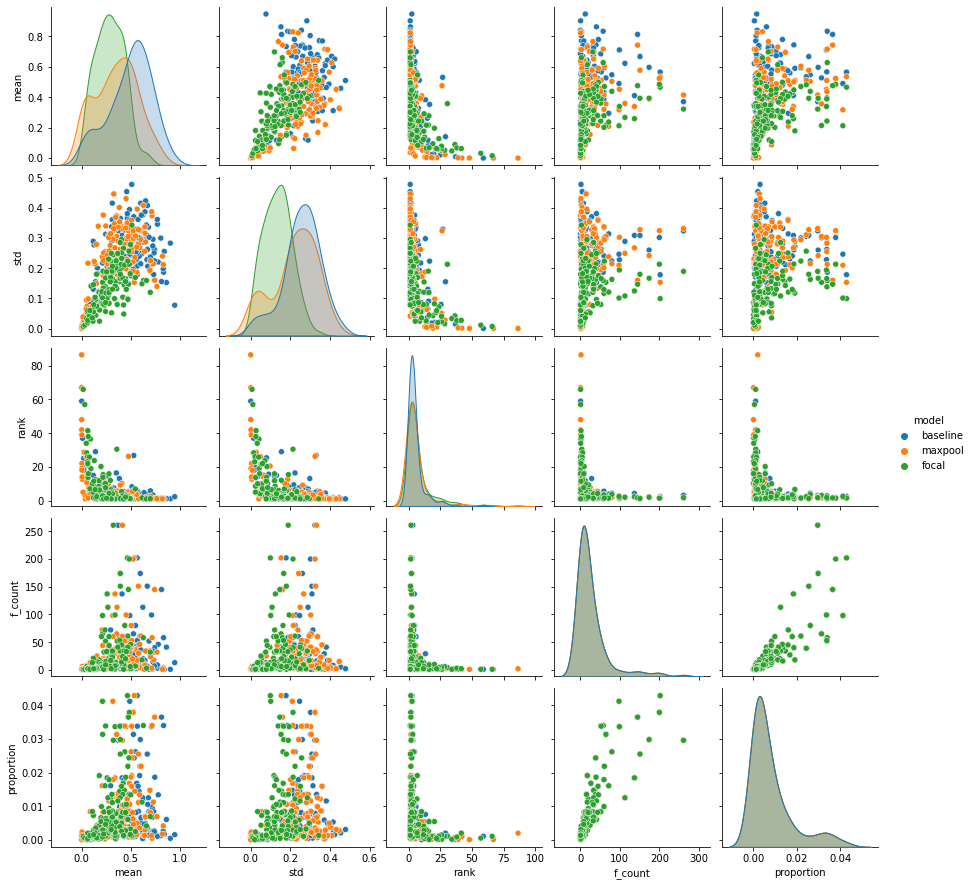

In [148]:
sns.pairplot(
    baseline_stat.\
    append(maxpool_stat, ignore_index=True).\
    append(focal_stat, ignore_index=True), 
    hue='model',
)

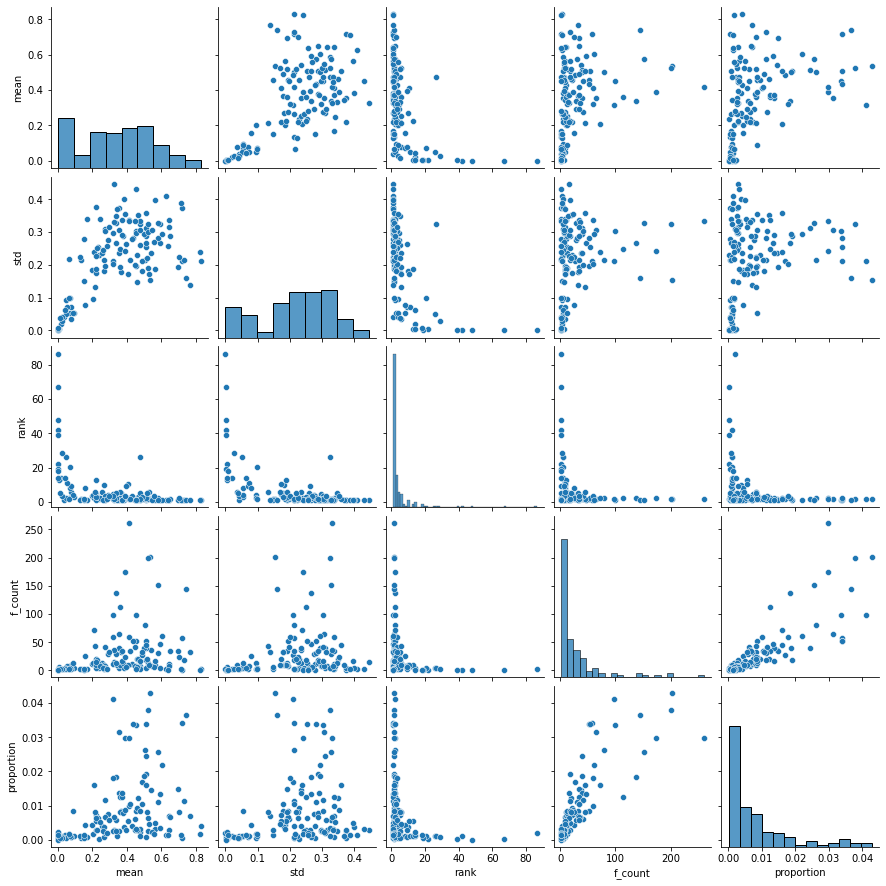

In [128]:
sns.pairplot(maxpool_stat)

In [159]:
pred_pd = pd.read_csv('focal_pred.csv')

In [162]:
(pred_pd.pred > 0.1).sum()

92000